In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install foolbox
import foolbox 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim

In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device1=torch.device('cpu')
print(device)

cuda


In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4845, 0.4903, 0.4508],[0.2135, 0.1970, 0.1911])
])

In [ ]:
train_set=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/ucm_train', transform=transformer)
valid_set=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/ucm_valid', transform=transformer)

batch_size_train=16
batch_size_valid=16
train_loader=DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader=DataLoader(valid_set, batch_size_valid, shuffle=True)

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 21) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model=AlexNet().to(device)

In [ ]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion=nn.CrossEntropyLoss()

In [ ]:
train_count=len(train_set)
valid_count=len(valid_set)

In [ ]:
print(train_count,valid_count)

1701 419


In [ ]:
best_accuracy=0.0
num_epochs=100

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    valid_loss=0.0
    valid_accuracy=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    model.eval()
    
    for data, target in valid_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
        
      # update-average-validation-loss 
      valid_loss += loss.item() * data.size(0)

      _,prediction=torch.max(output.data,1)
      valid_accuracy+=int(torch.sum(prediction==target.data))
     
      
    
    valid_accuracy=valid_accuracy/valid_count
    valid_loss=valid_loss/valid_count
       
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+ ' Valid Loss:'+str(valid_loss)+' Valid Accuracy:'+str(valid_accuracy))

    if(valid_accuracy>best_accuracy):
      torch.save(model.state_dict(), '/content/drive/MyDrive/alexnet/model.pth')
      best_accuracy=valid_accuracy
      print("Best accuracy: ", best_accuracy)


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/alexnet/model.pth'))

<All keys matched successfully>

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Test Accuracy of the model: {} '.format(correct / total))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test Accuracy of the model: 0.6539379474940334 


In [ ]:
model=model.eval()

In [ ]:
bounds = (0, 1)
fmodel = foolbox.PyTorchModel(model, bounds=bounds)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
dir='/content/drive/MyDrive/ucm_train'
classes = os.listdir(dir)
classes.sort()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.6420047581195831


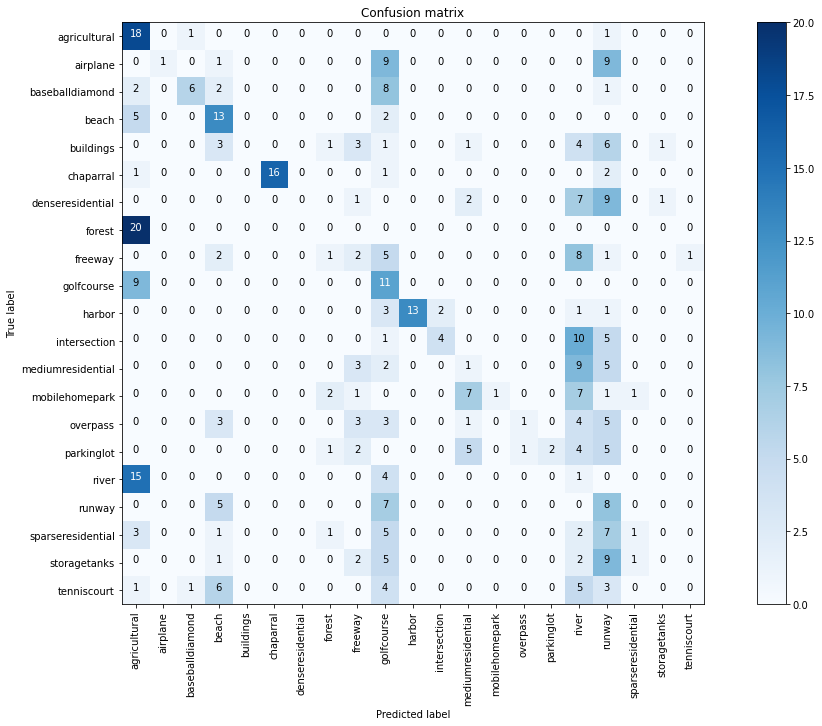

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ContrastReductionAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6706443727016449


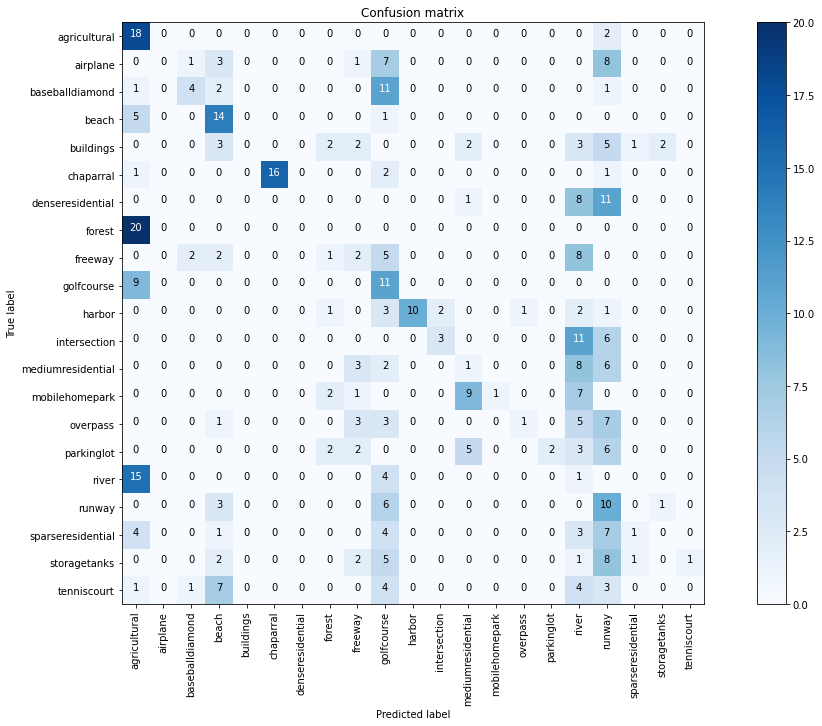

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.VirtualAdversarialAttack(steps=1)
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6348448693752289


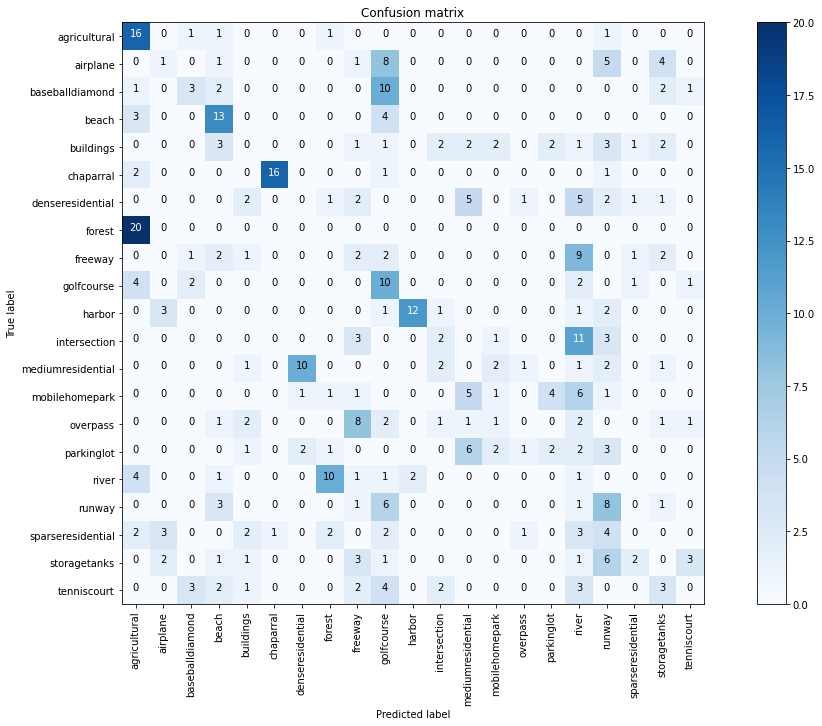

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.DDNAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6276849508285522


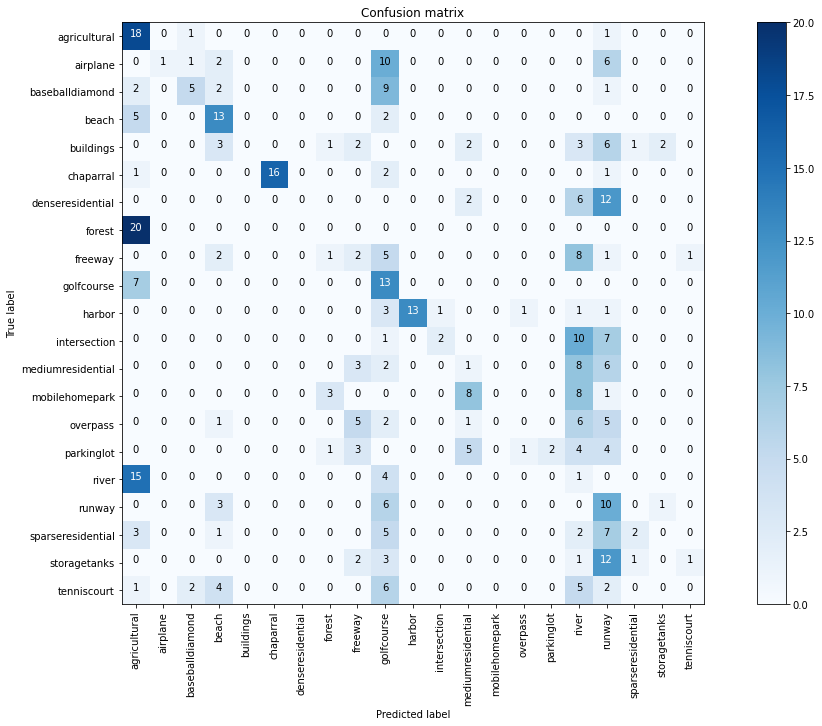

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ProjectedGradientDescentAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6491646766662598


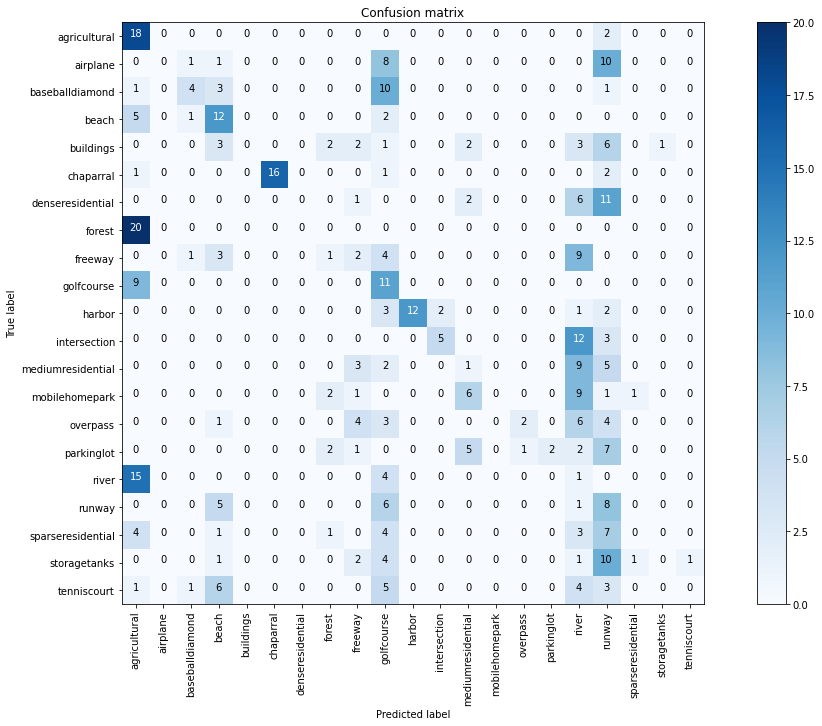

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfProjectedGradientDescentAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6443913877010345


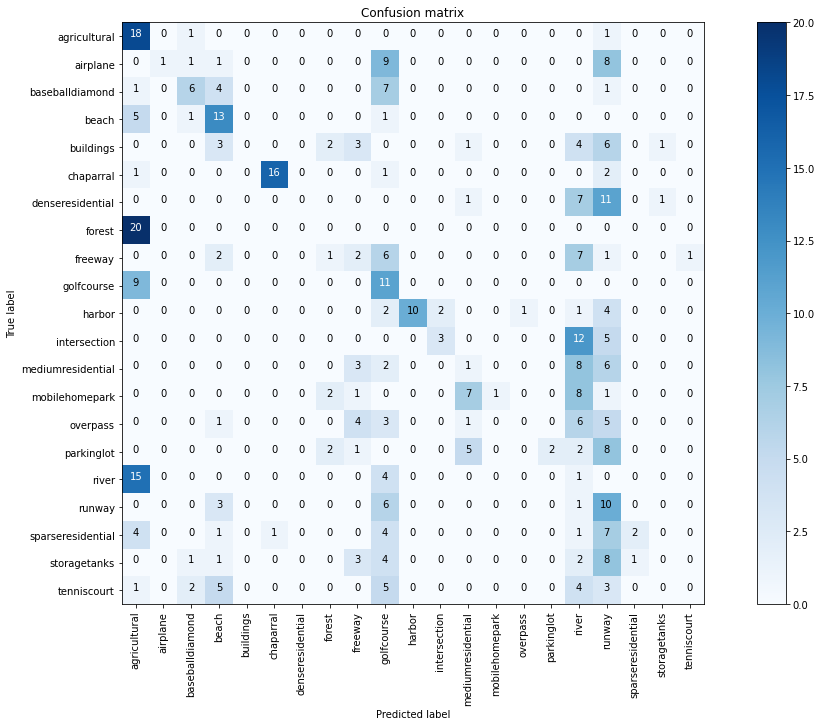

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2BasicIterativeAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.646778017282486


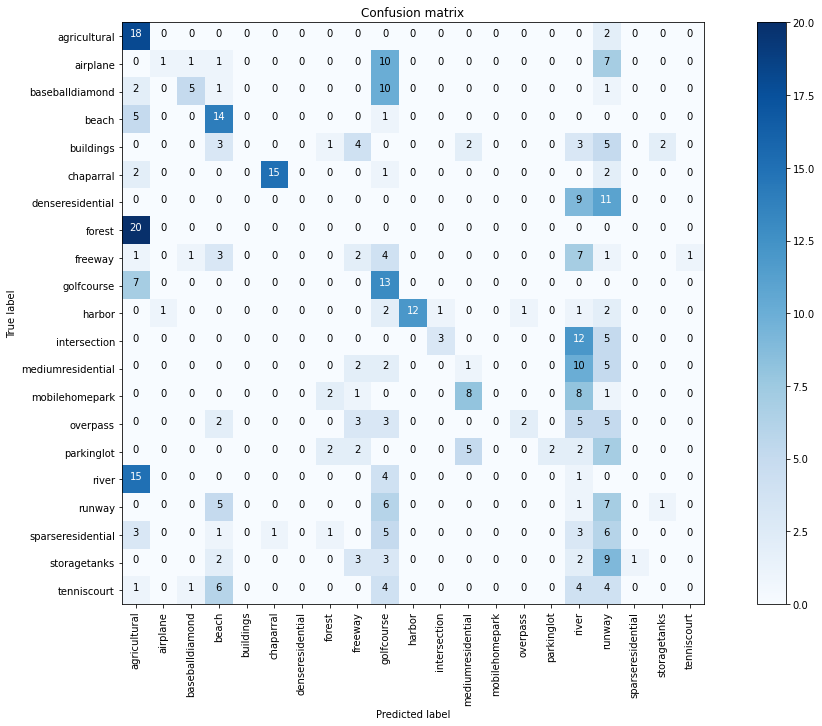

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfBasicIterativeAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6515513062477112


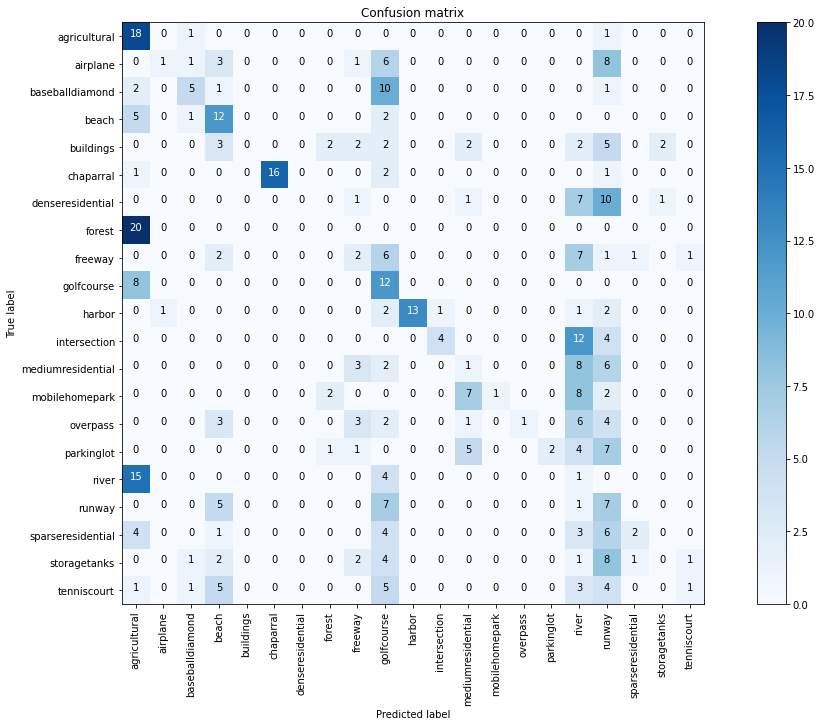

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2FastGradientAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.656324565410614


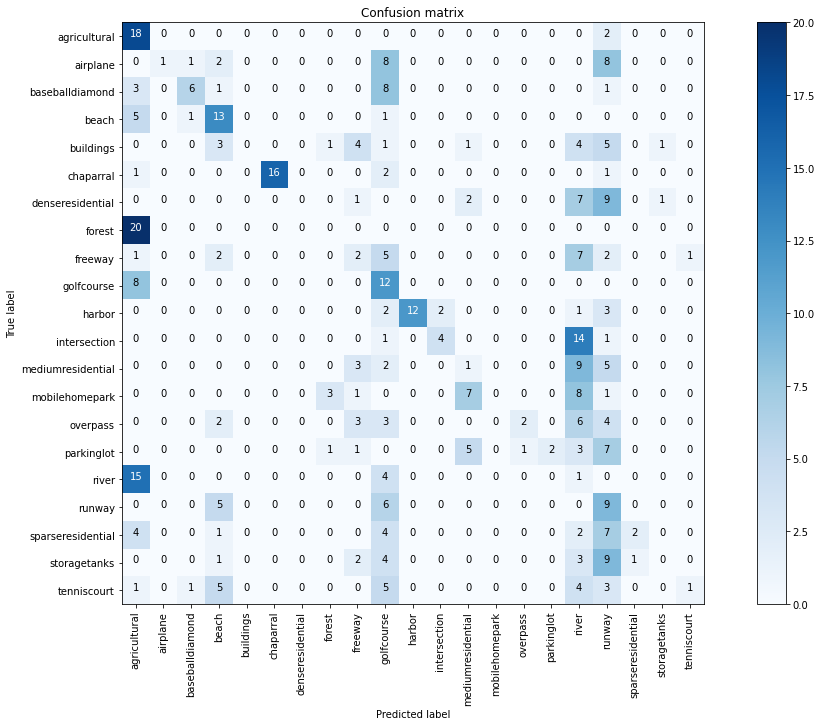

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfFastGradientAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6515513062477112


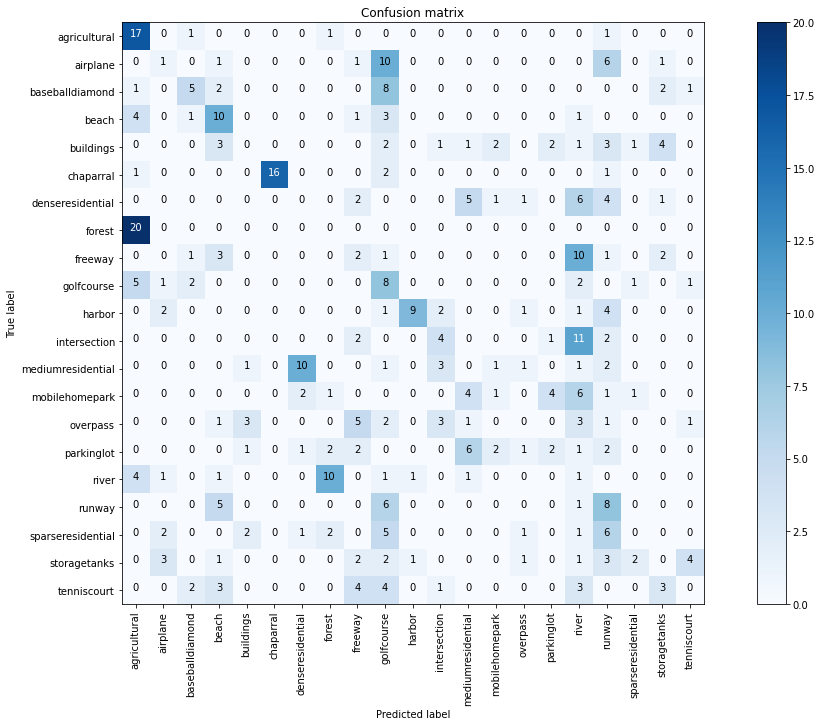

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6491646766662598


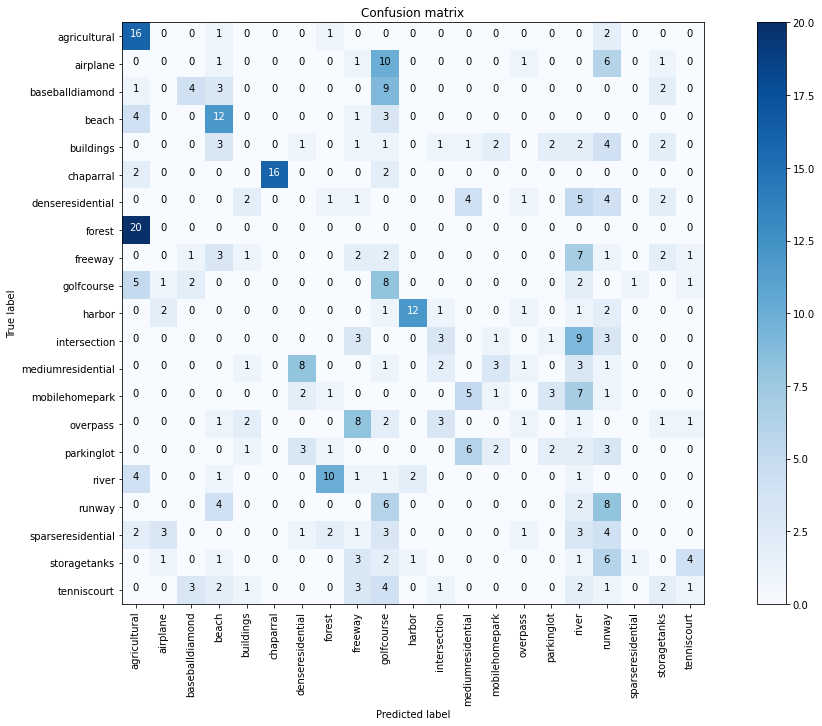

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6515513062477112


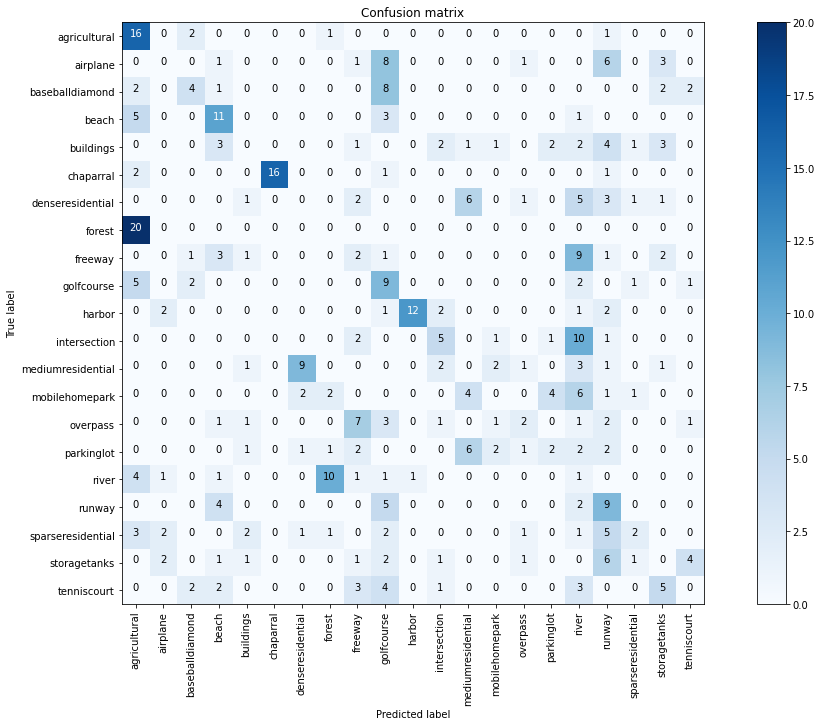

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6443913877010345


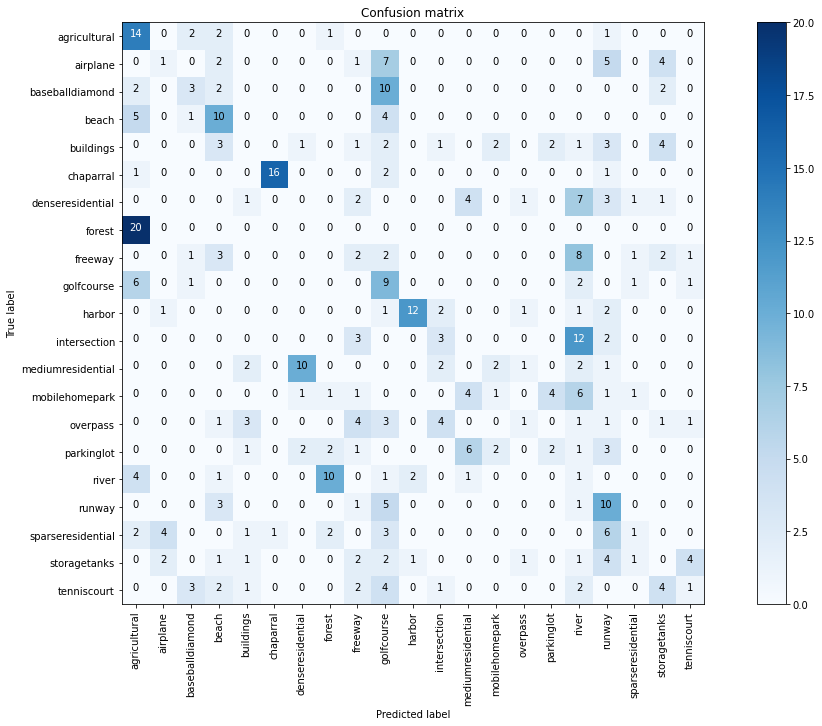

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.646778017282486


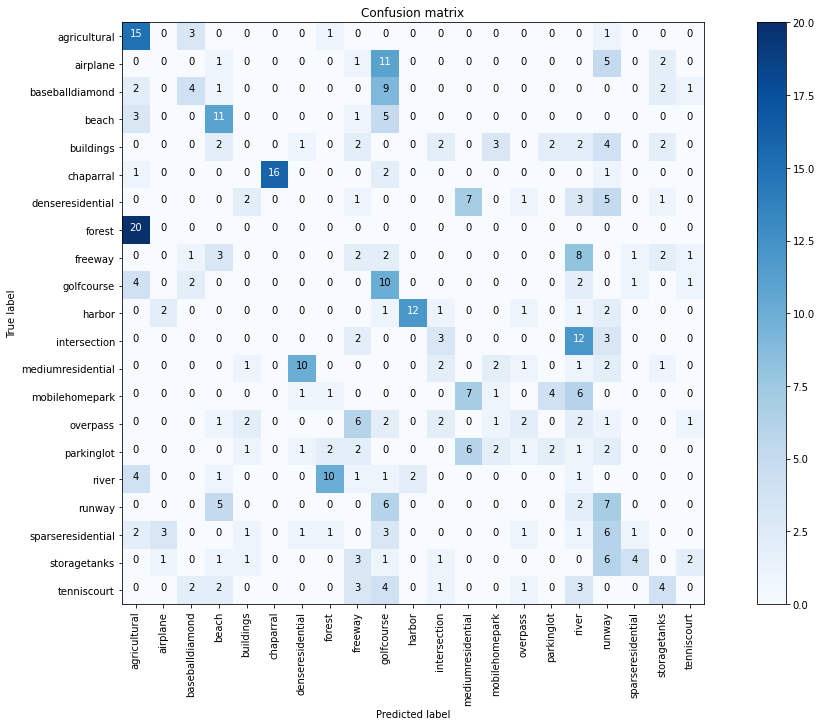

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfRepeatedAdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6491646766662598


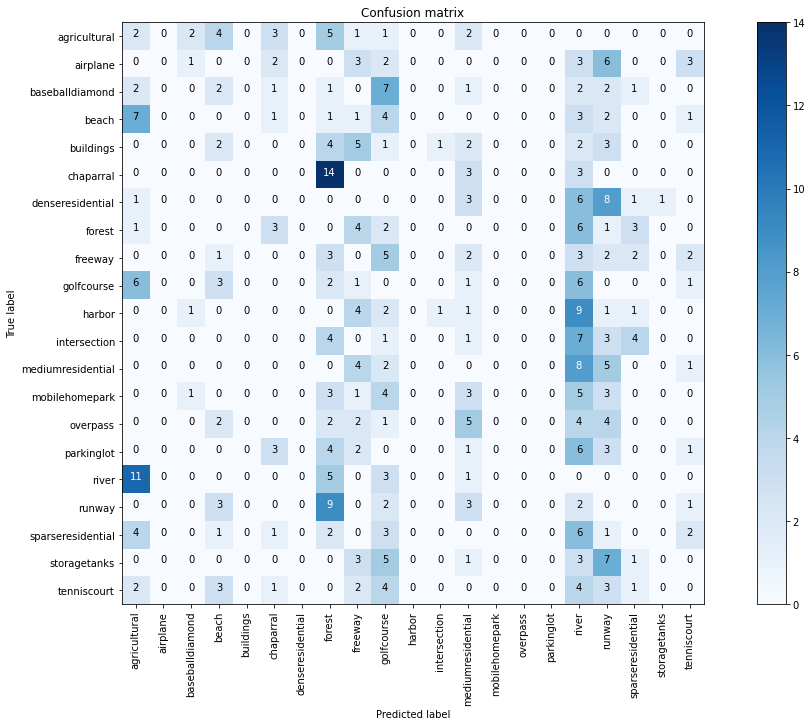

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.NewtonFoolAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6634844839572906


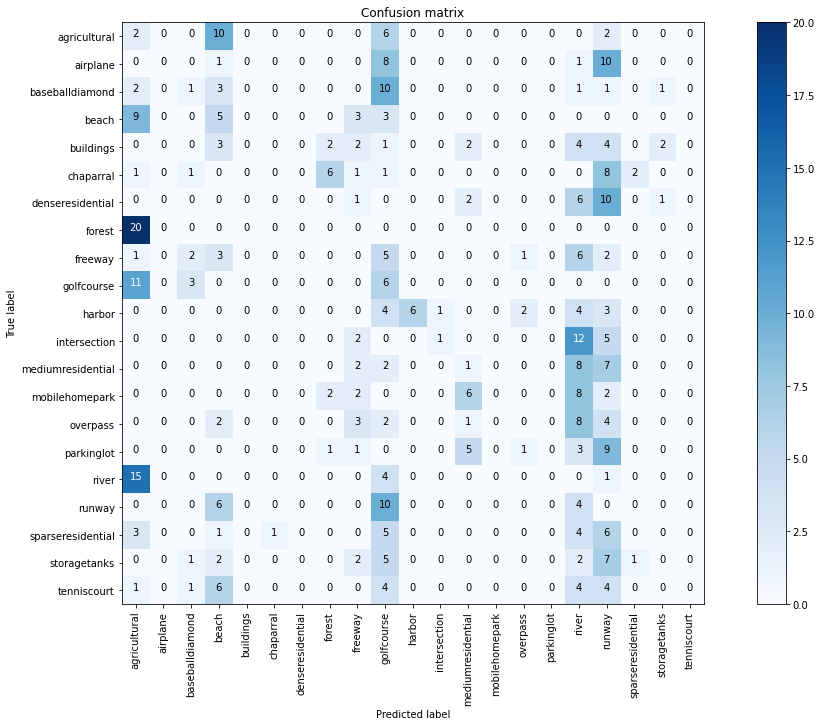

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfDeepFoolAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.646778017282486


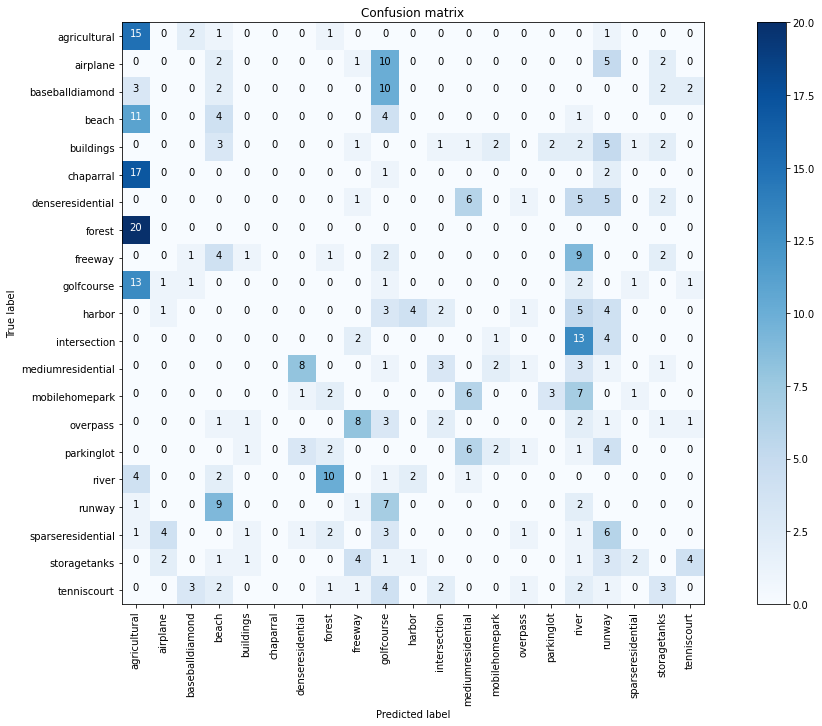

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.SaltAndPepperNoiseAttack()  
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.6491646766662598


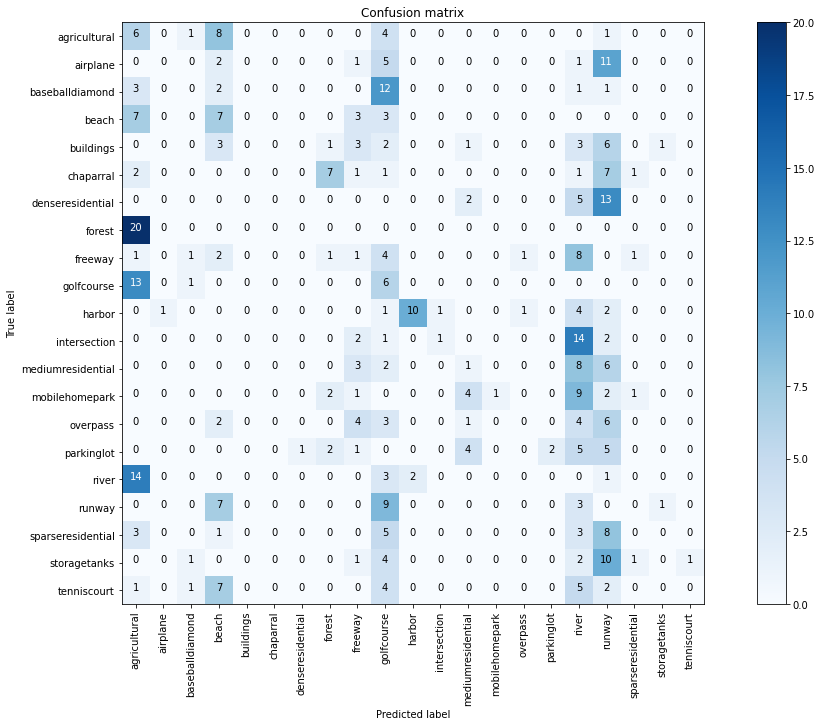

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2DeepFoolAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6396181285381317


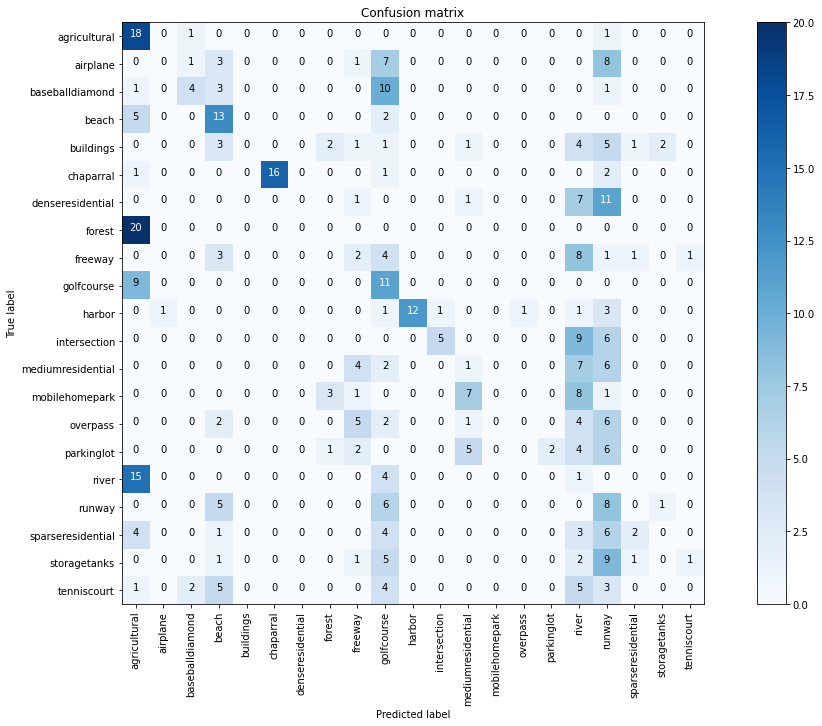

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6539379358291626


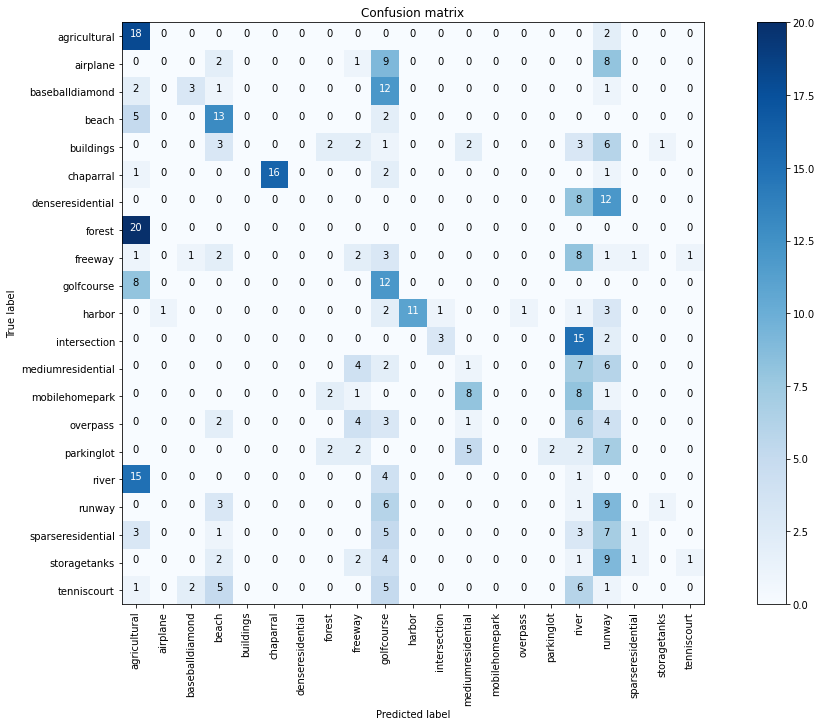

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6348448693752289


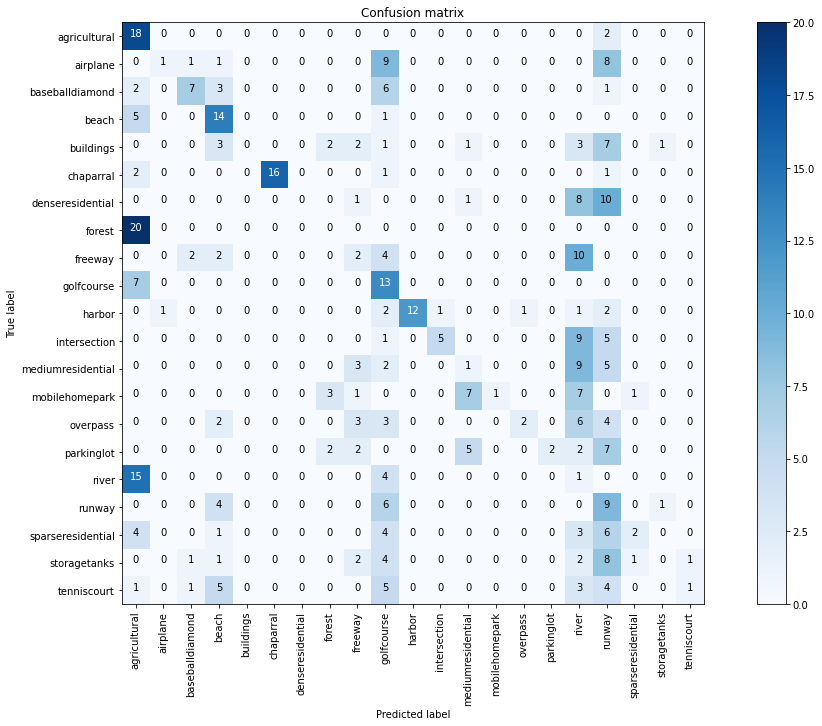

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6396181285381317


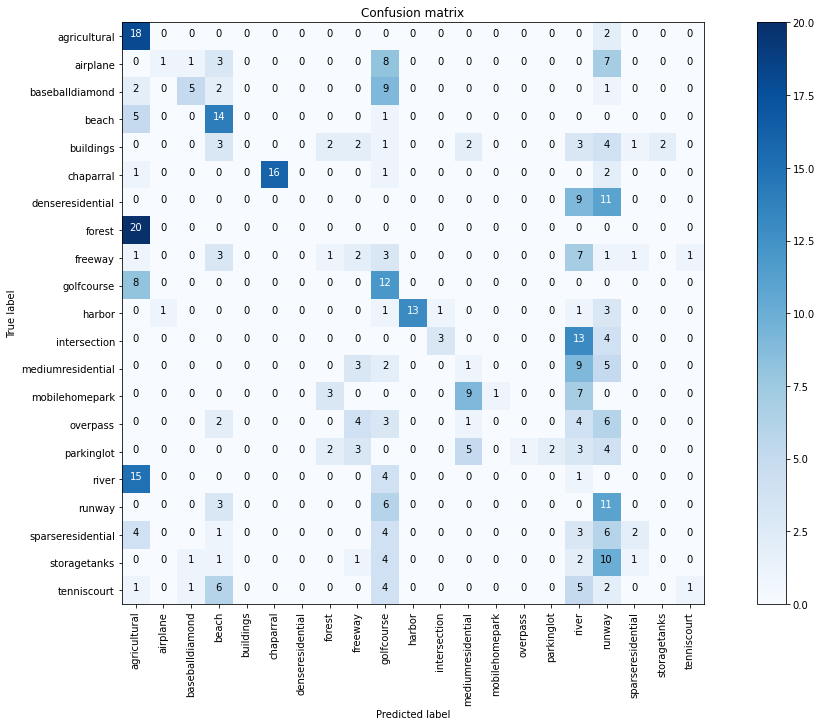

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6587111949920654


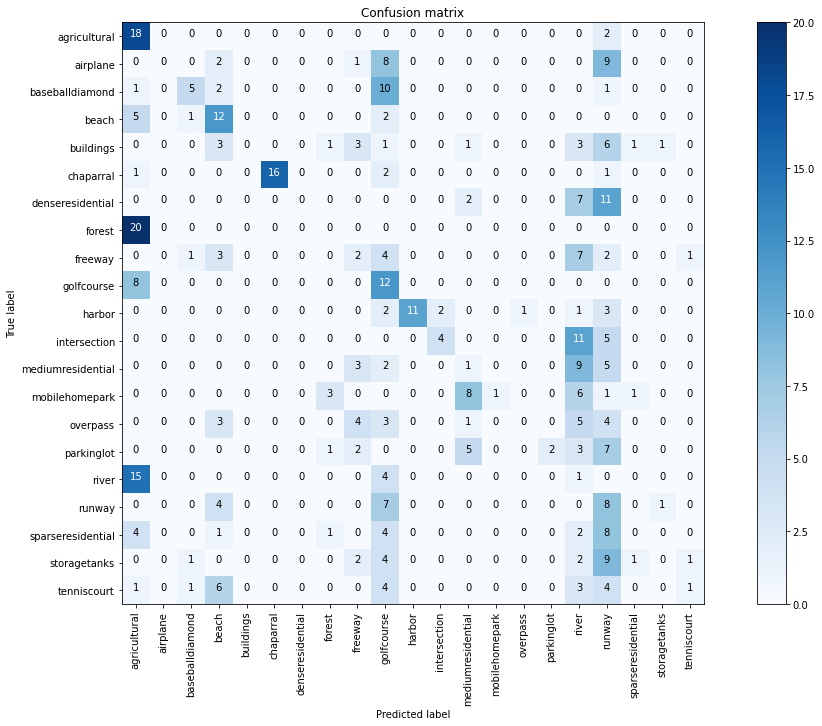

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6515513062477112


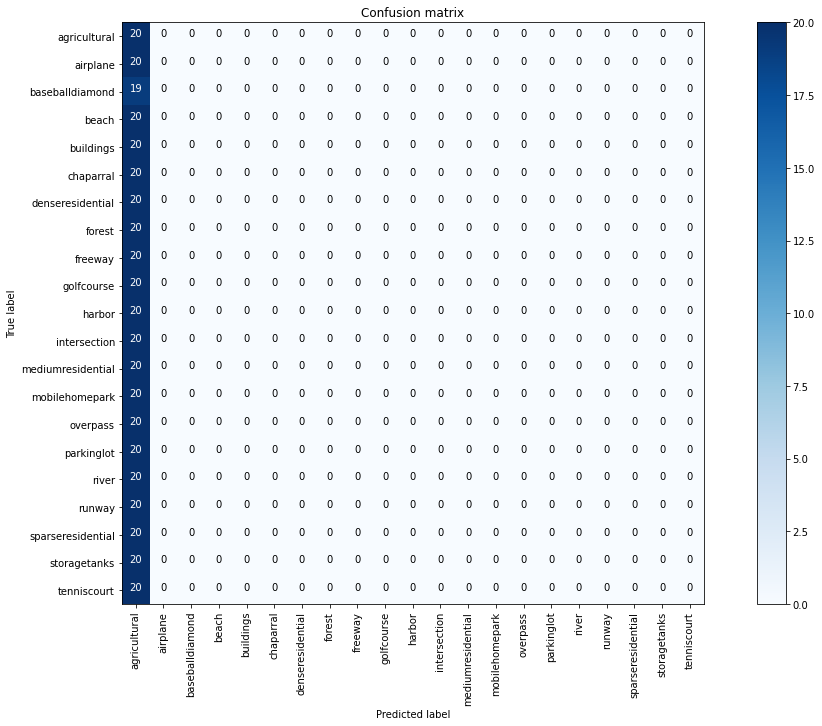

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2CarliniWagnerAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6587111949920654


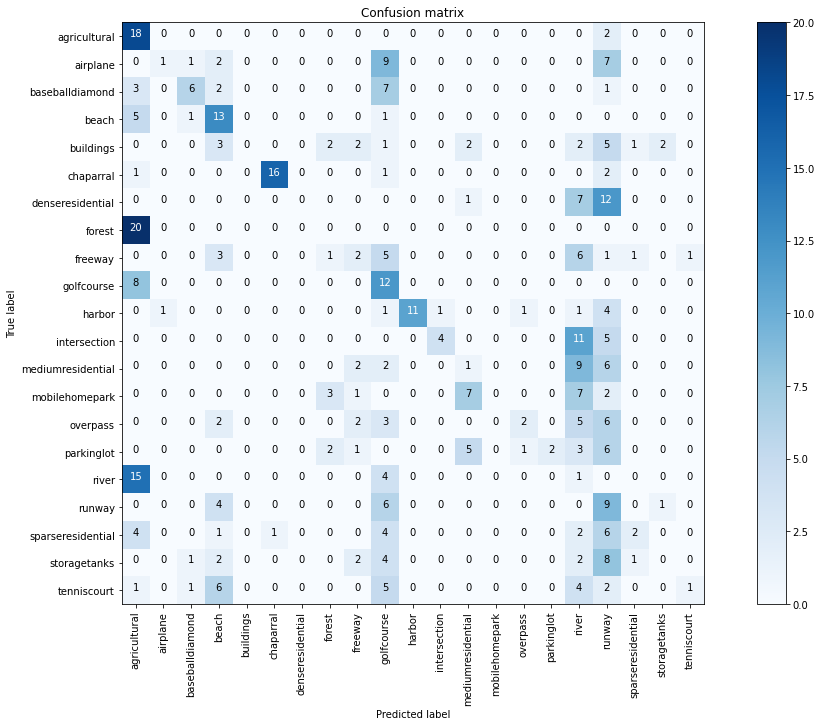

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6324582099914551


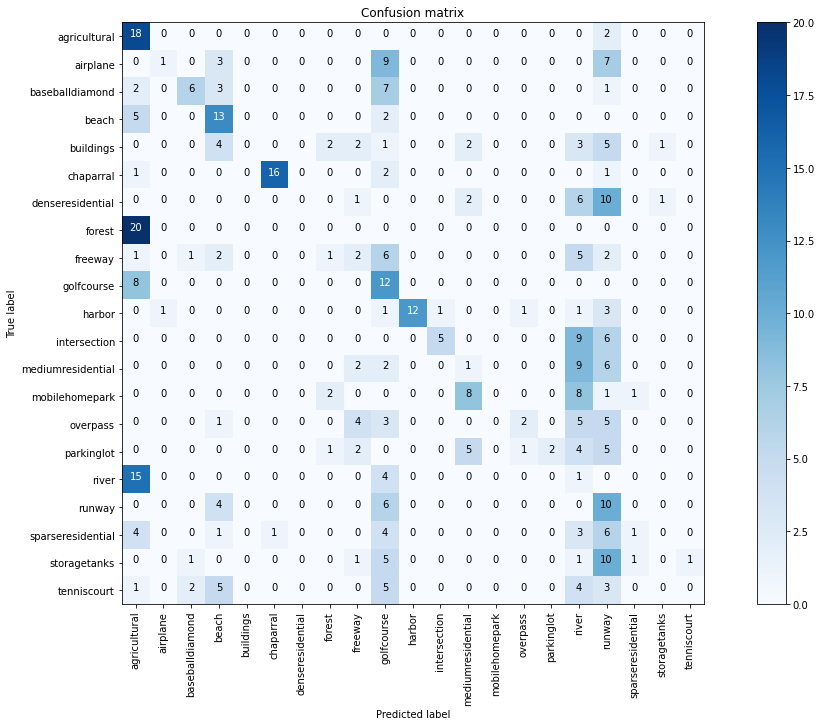

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGSM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6324582099914551


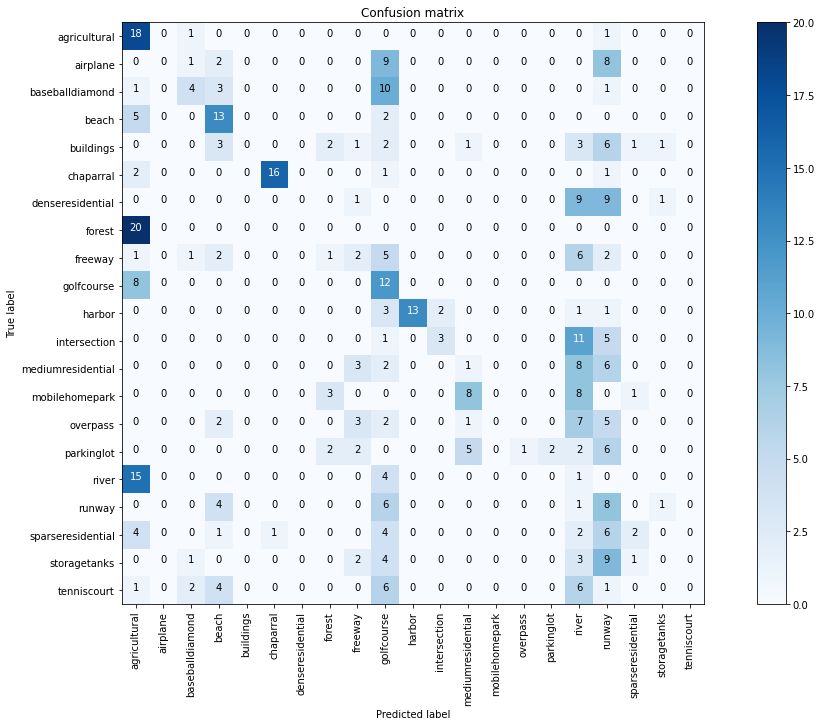

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2PGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6372314989566803


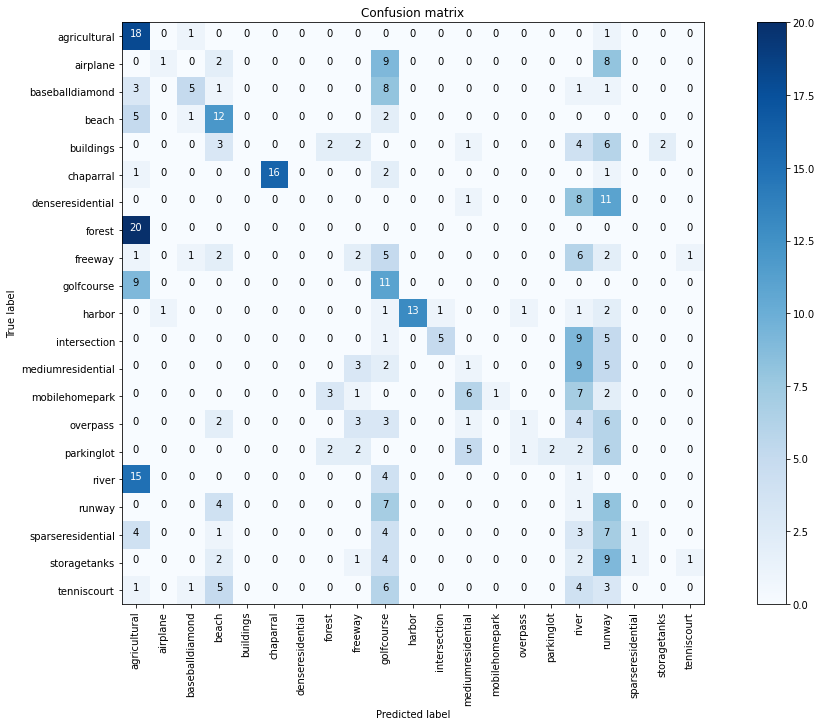

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfPGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.6420047581195831


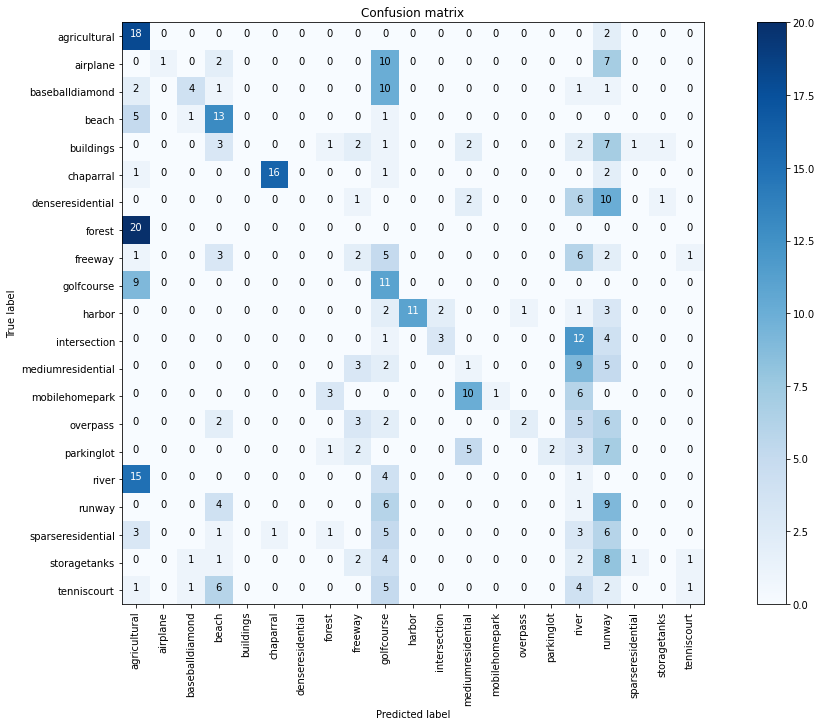

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.PGD()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)